In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

label_cnt_df = label_df.groupby('label').size().reset_index().rename({0: 'label_cnt'}, axis=1)
label_model_cnt_df = label_df.groupby(['server_model', 'label']).size().reset_index()\
    .rename({0: 'label_model_cnt'}, axis=1)
label_model_cnt_df = label_model_cnt_df.merge(label_cnt_df, on='label', how='left')
label_model_cnt_df['model/label'] = label_model_cnt_df['label_model_cnt'] / label_model_cnt_df['label_cnt']


(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [14]:
log_df['category'] = [item[0] for item in log_df['msg_lower'].str.split(' ')]

In [15]:
np.unique(log_df['category'].values)

array(['add-in', 'battery', 'boot', 'button', 'cable',
       'cable/interconnect', 'chassis', 'chip', 'critical', 'device',
       'drive', 'event', 'fan', 'hex', 'lan', 'management', 'memory',
       'microcontroller', 'microcontroller/coprocessor', 'oem', 'os',
       'physical', 'power', 'processor', 'request', 'reserved', 'session',
       'slot', 'slot/connector', 'system', 'temperature', 'terminator',
       'unknown', 'version', 'watchdog', 'watchdog2'], dtype=object)

In [19]:
category_df = log_df.groupby('category').size().reset_index()

In [30]:
category_df[category_df[0] > 500]['category'].values

array(['button', 'critical', 'drive', 'event', 'fan', 'management',
       'memory', 'microcontroller', 'microcontroller/coprocessor', 'oem',
       'os', 'power', 'processor', 'slot', 'slot/connector', 'system',
       'temperature', 'unknown', 'watchdog', 'watchdog2'], dtype=object)

In [4]:
counter_map = {}
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time_ts = row['fault_time_ts']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')
    df_tmp = sub_log.tail(20)
    k = '%d'%(row['label'])
    if not k in counter_map:
        counter_map[k] = Counter()
    counter_map[k].update(np.unique(df_tmp['msg_id'].values.tolist()))
for k in counter_map:
    counter_map[k] = [item[0] for item in counter_map[k].most_common()[:50]]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [07:25<00:00, 37.29it/s]


In [11]:
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time_ts = row['fault_time_ts']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')
    df_tmp = sub_log.tail(20)
    
    features = []
    for label in range(4):
        intersect = np.intersect1d(np.unique(df_tmp['msg_id'].values), counter_map['%d'%label])
        features.append(len(intersect) / len(counter_map['%d'%label]))
    print(features)

  0%|                                                                                                                                                                  | 8/16604 [00:00<07:49, 35.37it/s]

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.02, 0.02]


  0%|▏                                                                                                                                                                | 16/16604 [00:00<07:32, 36.64it/s]

[0.0, 0.0, 0.02, 0.02]
[0.08, 0.08, 0.06, 0.06]
[0.14, 0.14, 0.12, 0.08]
[0.2, 0.24, 0.22, 0.24]
[0.1, 0.12, 0.08, 0.04]
[0.24, 0.24, 0.22, 0.16]
[0.12, 0.14, 0.12, 0.1]
[0.1, 0.1, 0.08, 0.06]
[0.04, 0.04, 0.02, 0.0]


  0%|▏                                                                                                                                                                | 24/16604 [00:00<07:34, 36.51it/s]

[0.24, 0.26, 0.24, 0.18]
[0.06, 0.08, 0.04, 0.04]
[0.12, 0.14, 0.1, 0.06]
[0.14, 0.14, 0.12, 0.1]
[0.14, 0.14, 0.12, 0.1]
[0.16, 0.22, 0.12, 0.1]
[0.16, 0.18, 0.16, 0.14]
[0.16, 0.16, 0.14, 0.14]
[0.06, 0.06, 0.04, 0.04]


  0%|▎                                                                                                                                                                | 32/16604 [00:00<07:37, 36.19it/s]

[0.14, 0.14, 0.12, 0.12]
[0.12, 0.14, 0.08, 0.04]
[0.1, 0.12, 0.08, 0.04]
[0.08, 0.08, 0.06, 0.02]
[0.14, 0.14, 0.12, 0.1]
[0.18, 0.24, 0.16, 0.16]
[0.1, 0.1, 0.08, 0.04]


  0%|▍                                                                                                                                                                | 40/16604 [00:01<07:56, 34.75it/s]

[0.22, 0.24, 0.2, 0.18]
[0.1, 0.1, 0.08, 0.04]
[0.2, 0.24, 0.16, 0.12]
[0.2, 0.22, 0.18, 0.2]
[0.08, 0.08, 0.06, 0.06]
[0.16, 0.2, 0.16, 0.16]
[0.24, 0.24, 0.2, 0.2]
[0.22, 0.24, 0.22, 0.18]
[0.08, 0.08, 0.06, 0.06]


  0%|▍                                                                                                                                                                | 48/16604 [00:01<07:50, 35.16it/s]

[0.08, 0.08, 0.06, 0.06]
[0.18, 0.18, 0.16, 0.16]
[0.08, 0.08, 0.06, 0.06]
[0.08, 0.08, 0.06, 0.06]
[0.16, 0.2, 0.18, 0.2]
[0.16, 0.2, 0.14, 0.14]
[0.1, 0.1, 0.08, 0.1]
[0.18, 0.22, 0.18, 0.18]


  0%|▌                                                                                                                                                                | 56/16604 [00:01<07:43, 35.73it/s]

[0.18, 0.2, 0.18, 0.16]
[0.08, 0.08, 0.08, 0.06]
[0.1, 0.14, 0.08, 0.08]
[0.08, 0.08, 0.06, 0.1]
[0.08, 0.08, 0.06, 0.06]
[0.08, 0.08, 0.08, 0.04]
[0.18, 0.2, 0.16, 0.16]
[0.08, 0.1, 0.06, 0.06]


  0%|▌                                                                                                                                                                | 64/16604 [00:01<07:40, 35.91it/s]

[0.16, 0.18, 0.18, 0.18]
[0.16, 0.16, 0.14, 0.14]
[0.2, 0.22, 0.2, 0.2]
[0.1, 0.1, 0.08, 0.08]
[0.02, 0.02, 0.02, 0.0]
[0.08, 0.08, 0.06, 0.06]
[0.2, 0.26, 0.18, 0.18]
[0.24, 0.28, 0.18, 0.14]


  0%|▋                                                                                                                                                                | 72/16604 [00:02<07:36, 36.18it/s]

[0.14, 0.16, 0.14, 0.12]
[0.06, 0.06, 0.06, 0.02]
[0.1, 0.12, 0.08, 0.08]
[0.18, 0.2, 0.16, 0.18]
[0.08, 0.08, 0.08, 0.08]
[0.06, 0.06, 0.06, 0.06]
[0.04, 0.04, 0.04, 0.02]
[0.1, 0.12, 0.14, 0.18]


  0%|▊                                                                                                                                                                | 80/16604 [00:02<07:35, 36.24it/s]

[0.16, 0.18, 0.18, 0.2]
[0.16, 0.18, 0.14, 0.18]
[0.08, 0.08, 0.06, 0.06]
[0.16, 0.18, 0.16, 0.18]
[0.18, 0.18, 0.18, 0.18]
[0.08, 0.08, 0.06, 0.06]
[0.08, 0.08, 0.08, 0.04]
[0.04, 0.04, 0.04, 0.04]


  1%|▊                                                                                                                                                                | 88/16604 [00:02<07:34, 36.31it/s]

[0.08, 0.08, 0.08, 0.08]
[0.14, 0.16, 0.14, 0.14]
[0.04, 0.04, 0.02, 0.02]
[0.08, 0.08, 0.06, 0.06]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.16, 0.16, 0.14, 0.1]
[0.14, 0.14, 0.12, 0.12]


  1%|▉                                                                                                                                                                | 96/16604 [00:02<07:35, 36.26it/s]

[0.2, 0.2, 0.18, 0.16]
[0.08, 0.08, 0.1, 0.1]
[0.16, 0.16, 0.16, 0.12]
[0.04, 0.04, 0.04, 0.04]
[0.16, 0.16, 0.14, 0.14]
[0.14, 0.2, 0.1, 0.08]
[0.22, 0.22, 0.18, 0.16]
[0.04, 0.04, 0.02, 0.02]


  1%|█                                                                                                                                                               | 104/16604 [00:02<07:32, 36.46it/s]

[0.1, 0.1, 0.1, 0.04]
[0.18, 0.18, 0.16, 0.16]
[0.2, 0.24, 0.16, 0.16]
[0.22, 0.22, 0.18, 0.16]
[0.16, 0.16, 0.14, 0.14]
[0.14, 0.14, 0.14, 0.14]
[0.2, 0.24, 0.16, 0.16]
[0.08, 0.08, 0.06, 0.06]


  1%|█                                                                                                                                                               | 112/16604 [00:03<07:29, 36.72it/s]

[0.12, 0.12, 0.08, 0.08]
[0.1, 0.1, 0.08, 0.08]
[0.02, 0.02, 0.02, 0.02]
[0.08, 0.1, 0.06, 0.08]
[0.02, 0.02, 0.02, 0.02]
[0.02, 0.02, 0.02, 0.02]
[0.1, 0.1, 0.08, 0.08]
[0.1, 0.1, 0.08, 0.08]


  1%|█▏                                                                                                                                                              | 120/16604 [00:03<07:30, 36.63it/s]

[0.1, 0.1, 0.08, 0.08]
[0.1, 0.1, 0.08, 0.08]
[0.06, 0.06, 0.04, 0.04]
[0.04, 0.04, 0.02, 0.02]
[0.1, 0.1, 0.08, 0.08]
[0.1, 0.1, 0.08, 0.08]
[0.12, 0.14, 0.14, 0.14]
[0.0, 0.0, 0.02, 0.0]


  1%|█▏                                                                                                                                                              | 128/16604 [00:03<07:34, 36.27it/s]

[0.18, 0.2, 0.18, 0.18]
[0.08, 0.08, 0.08, 0.02]
[0.14, 0.16, 0.14, 0.16]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.14, 0.12]
[0.18, 0.18, 0.18, 0.12]
[0.02, 0.02, 0.02, 0.0]
[0.06, 0.06, 0.06, 0.04]


  1%|█▎                                                                                                                                                              | 136/16604 [00:03<07:32, 36.37it/s]

[0.06, 0.06, 0.08, 0.08]
[0.16, 0.16, 0.18, 0.12]
[0.02, 0.02, 0.02, 0.0]
[0.14, 0.18, 0.14, 0.2]
[0.04, 0.04, 0.04, 0.04]
[0.0, 0.0, 0.02, 0.0]
[0.14, 0.14, 0.14, 0.08]
[0.04, 0.04, 0.04, 0.02]


  1%|█▍                                                                                                                                                              | 144/16604 [00:03<07:28, 36.70it/s]

[0.04, 0.04, 0.04, 0.02]
[0.0, 0.0, 0.0, 0.0]
[0.08, 0.08, 0.08, 0.06]
[0.02, 0.02, 0.04, 0.0]
[0.18, 0.18, 0.18, 0.12]
[0.06, 0.06, 0.08, 0.02]
[0.02, 0.02, 0.04, 0.0]
[0.04, 0.04, 0.06, 0.0]


  1%|█▍                                                                                                                                                              | 152/16604 [00:04<07:29, 36.59it/s]

[0.16, 0.16, 0.16, 0.12]
[0.08, 0.08, 0.08, 0.02]
[0.14, 0.18, 0.14, 0.18]
[0.14, 0.14, 0.12, 0.12]
[0.16, 0.16, 0.16, 0.14]
[0.14, 0.14, 0.12, 0.1]
[0.14, 0.14, 0.12, 0.12]
[0.18, 0.24, 0.18, 0.22]


  1%|█▌                                                                                                                                                              | 160/16604 [00:04<07:27, 36.76it/s]

[0.06, 0.06, 0.06, 0.06]
[0.16, 0.18, 0.14, 0.16]
[0.02, 0.02, 0.04, 0.0]
[0.2, 0.2, 0.2, 0.14]
[0.06, 0.06, 0.06, 0.02]
[0.12, 0.12, 0.1, 0.1]
[0.12, 0.12, 0.12, 0.12]
[0.16, 0.22, 0.18, 0.26]


  1%|█▌                                                                                                                                                              | 168/16604 [00:04<07:26, 36.79it/s]

[0.14, 0.14, 0.12, 0.12]
[0.06, 0.06, 0.08, 0.02]
[0.06, 0.06, 0.08, 0.02]
[0.08, 0.08, 0.08, 0.04]
[0.18, 0.18, 0.16, 0.16]
[0.04, 0.04, 0.06, 0.02]
[0.04, 0.04, 0.04, 0.04]
[0.12, 0.12, 0.1, 0.1]


  1%|█▋                                                                                                                                                              | 176/16604 [00:04<07:27, 36.75it/s]

[0.12, 0.12, 0.12, 0.12]
[0.14, 0.18, 0.14, 0.18]
[0.02, 0.02, 0.04, 0.0]
[0.12, 0.14, 0.12, 0.1]
[0.18, 0.2, 0.16, 0.16]
[0.04, 0.04, 0.04, 0.04]
[0.18, 0.18, 0.16, 0.12]
[0.02, 0.02, 0.02, 0.02]


  1%|█▊                                                                                                                                                              | 184/16604 [00:05<07:29, 36.57it/s]

[0.04, 0.04, 0.06, 0.04]
[0.02, 0.02, 0.02, 0.04]
[0.04, 0.04, 0.04, 0.04]
[0.1, 0.1, 0.08, 0.08]
[0.08, 0.08, 0.06, 0.06]
[0.18, 0.2, 0.18, 0.14]
[0.06, 0.06, 0.06, 0.02]
[0.14, 0.14, 0.12, 0.12]


  1%|█▊                                                                                                                                                              | 192/16604 [00:05<07:26, 36.78it/s]

[0.02, 0.02, 0.04, 0.0]
[0.06, 0.06, 0.08, 0.02]
[0.04, 0.04, 0.04, 0.04]
[0.14, 0.18, 0.14, 0.2]
[0.18, 0.2, 0.16, 0.18]
[0.02, 0.02, 0.02, 0.02]
[0.1, 0.1, 0.08, 0.08]
[0.06, 0.06, 0.08, 0.04]


  1%|█▉                                                                                                                                                              | 200/16604 [00:05<07:26, 36.75it/s]

[0.02, 0.02, 0.02, 0.0]
[0.16, 0.16, 0.14, 0.14]
[0.18, 0.22, 0.16, 0.2]
[0.1, 0.1, 0.1, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.16, 0.16, 0.14, 0.14]
[0.1, 0.1, 0.08, 0.08]


  1%|██                                                                                                                                                              | 208/16604 [00:05<07:26, 36.69it/s]

[0.16, 0.18, 0.16, 0.16]
[0.18, 0.2, 0.18, 0.18]
[0.14, 0.14, 0.12, 0.12]
[0.02, 0.02, 0.02, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.1, 0.1, 0.08, 0.08]
[0.14, 0.14, 0.12, 0.12]
[0.1, 0.1, 0.08, 0.08]


  1%|██                                                                                                                                                              | 216/16604 [00:05<07:28, 36.54it/s]

[0.14, 0.14, 0.12, 0.12]
[0.06, 0.06, 0.06, 0.02]
[0.02, 0.02, 0.02, 0.02]
[0.04, 0.04, 0.04, 0.04]
[0.12, 0.12, 0.12, 0.12]
[0.16, 0.16, 0.14, 0.14]
[0.16, 0.16, 0.14, 0.14]
[0.18, 0.18, 0.18, 0.12]


  1%|██▏                                                                                                                                                             | 224/16604 [00:06<07:27, 36.61it/s]

[0.06, 0.06, 0.06, 0.02]
[0.16, 0.16, 0.14, 0.14]
[0.06, 0.06, 0.06, 0.04]
[0.12, 0.12, 0.1, 0.08]
[0.22, 0.22, 0.2, 0.16]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.14, 0.12]
[0.12, 0.12, 0.1, 0.1]


  1%|██▏                                                                                                                                                             | 232/16604 [00:06<07:24, 36.87it/s]

[0.18, 0.18, 0.18, 0.1]
[0.02, 0.02, 0.02, 0.02]
[0.16, 0.16, 0.14, 0.12]
[0.08, 0.08, 0.1, 0.1]
[0.08, 0.08, 0.08, 0.04]
[0.24, 0.24, 0.22, 0.16]
[0.24, 0.24, 0.22, 0.16]
[0.12, 0.12, 0.1, 0.1]


  1%|██▎                                                                                                                                                             | 240/16604 [00:06<07:24, 36.81it/s]

[0.1, 0.1, 0.08, 0.08]
[0.16, 0.16, 0.14, 0.14]
[0.18, 0.18, 0.16, 0.16]
[0.12, 0.12, 0.14, 0.14]
[0.16, 0.16, 0.14, 0.14]
[0.06, 0.06, 0.02, 0.02]
[0.08, 0.08, 0.06, 0.06]
[0.04, 0.04, 0.04, 0.04]


  1%|██▍                                                                                                                                                             | 248/16604 [00:06<07:27, 36.53it/s]

[0.14, 0.14, 0.12, 0.12]
[0.1, 0.1, 0.1, 0.1]
[0.02, 0.02, 0.02, 0.02]
[0.02, 0.02, 0.02, 0.02]
[0.02, 0.02, 0.0, 0.0]
[0.1, 0.12, 0.06, 0.06]
[0.14, 0.14, 0.12, 0.12]
[0.1, 0.1, 0.08, 0.08]


  2%|██▍                                                                                                                                                             | 256/16604 [00:07<07:27, 36.53it/s]

[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.18, 0.14, 0.18]
[0.1, 0.1, 0.08, 0.08]
[0.1, 0.12, 0.08, 0.1]
[0.06, 0.06, 0.06, 0.02]
[0.18, 0.22, 0.18, 0.18]


  2%|██▌                                                                                                                                                             | 264/16604 [00:07<07:26, 36.64it/s]

[0.1, 0.1, 0.1, 0.06]
[0.14, 0.14, 0.12, 0.12]
[0.12, 0.12, 0.1, 0.1]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.12, 0.12]
[0.14, 0.14, 0.12, 0.12]
[0.04, 0.04, 0.04, 0.04]


  2%|██▌                                                                                                                                                             | 272/16604 [00:07<07:24, 36.73it/s]

[0.1, 0.1, 0.08, 0.08]
[0.14, 0.14, 0.12, 0.12]
[0.1, 0.1, 0.08, 0.08]
[0.14, 0.14, 0.12, 0.08]
[0.02, 0.02, 0.04, 0.0]
[0.1, 0.1, 0.1, 0.08]
[0.18, 0.24, 0.18, 0.22]
[0.06, 0.06, 0.06, 0.02]


  2%|██▋                                                                                                                                                             | 280/16604 [00:07<07:24, 36.70it/s]

[0.16, 0.2, 0.16, 0.16]
[0.02, 0.02, 0.02, 0.02]
[0.06, 0.06, 0.06, 0.04]
[0.04, 0.04, 0.04, 0.04]
[0.02, 0.02, 0.02, 0.02]
[0.06, 0.06, 0.06, 0.04]
[0.06, 0.06, 0.02, 0.02]
[0.14, 0.16, 0.12, 0.12]


  2%|██▊                                                                                                                                                             | 288/16604 [00:07<07:25, 36.63it/s]

[0.18, 0.18, 0.12, 0.1]
[0.18, 0.18, 0.12, 0.1]
[0.14, 0.16, 0.12, 0.12]
[0.22, 0.22, 0.14, 0.12]
[0.12, 0.14, 0.12, 0.14]
[0.16, 0.16, 0.16, 0.12]
[0.18, 0.18, 0.18, 0.1]
[0.06, 0.06, 0.08, 0.04]


  2%|██▊                                                                                                                                                             | 296/16604 [00:08<07:24, 36.69it/s]

[0.06, 0.06, 0.06, 0.02]
[0.04, 0.04, 0.04, 0.02]
[0.12, 0.12, 0.12, 0.08]
[0.08, 0.08, 0.08, 0.06]
[0.04, 0.04, 0.04, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.04, 0.04, 0.04, 0.02]


  2%|██▉                                                                                                                                                             | 304/16604 [00:08<07:28, 36.31it/s]

[0.12, 0.12, 0.12, 0.04]
[0.1, 0.1, 0.1, 0.02]
[0.1, 0.1, 0.08, 0.08]
[0.04, 0.04, 0.04, 0.02]
[0.02, 0.02, 0.04, 0.02]
[0.0, 0.0, 0.02, 0.0]
[0.04, 0.04, 0.06, 0.02]
[0.1, 0.1, 0.08, 0.08]


  2%|███                                                                                                                                                             | 312/16604 [00:08<07:23, 36.76it/s]

[0.02, 0.02, 0.02, 0.02]
[0.12, 0.12, 0.12, 0.12]
[0.24, 0.24, 0.22, 0.18]
[0.06, 0.06, 0.06, 0.02]
[0.1, 0.1, 0.1, 0.06]
[0.1, 0.1, 0.08, 0.08]
[0.12, 0.12, 0.08, 0.06]
[0.12, 0.12, 0.08, 0.08]


  2%|███                                                                                                                                                             | 320/16604 [00:08<07:24, 36.64it/s]

[0.26, 0.22, 0.12, 0.06]
[0.12, 0.12, 0.1, 0.08]
[0.16, 0.18, 0.08, 0.08]
[0.12, 0.12, 0.08, 0.06]
[0.26, 0.22, 0.12, 0.06]
[0.1, 0.1, 0.04, 0.02]
[0.1, 0.1, 0.04, 0.02]
[0.08, 0.08, 0.08, 0.08]


  2%|███▏                                                                                                                                                            | 328/16604 [00:09<07:24, 36.59it/s]

[0.18, 0.2, 0.1, 0.08]
[0.24, 0.22, 0.12, 0.08]
[0.24, 0.2, 0.12, 0.06]
[0.2, 0.16, 0.12, 0.08]
[0.0, 0.0, 0.0, 0.0]
[0.22, 0.2, 0.1, 0.08]
[0.26, 0.22, 0.12, 0.06]
[0.1, 0.1, 0.08, 0.06]


  2%|███▏                                                                                                                                                            | 336/16604 [00:09<07:23, 36.66it/s]

[0.2, 0.16, 0.12, 0.08]
[0.24, 0.24, 0.14, 0.08]
[0.2, 0.2, 0.14, 0.12]
[0.06, 0.08, 0.02, 0.0]
[0.02, 0.02, 0.02, 0.0]
[0.02, 0.02, 0.02, 0.0]
[0.18, 0.18, 0.12, 0.06]
[0.16, 0.18, 0.08, 0.06]


  2%|███▎                                                                                                                                                            | 344/16604 [00:09<07:24, 36.60it/s]

[0.2, 0.18, 0.1, 0.06]
[0.1, 0.08, 0.06, 0.06]
[0.28, 0.24, 0.14, 0.08]
[0.06, 0.06, 0.06, 0.06]
[0.06, 0.06, 0.06, 0.04]
[0.26, 0.22, 0.12, 0.06]
[0.16, 0.16, 0.08, 0.06]
[0.2, 0.16, 0.1, 0.06]


  2%|███▍                                                                                                                                                            | 352/16604 [00:09<07:24, 36.60it/s]

[0.28, 0.24, 0.14, 0.08]
[0.04, 0.04, 0.04, 0.02]
[0.26, 0.22, 0.12, 0.08]
[0.06, 0.06, 0.06, 0.06]
[0.12, 0.12, 0.08, 0.06]
[0.16, 0.16, 0.08, 0.06]
[0.26, 0.22, 0.12, 0.08]
[0.16, 0.16, 0.08, 0.06]


  2%|███▍                                                                                                                                                            | 360/16604 [00:09<07:24, 36.53it/s]

[0.2, 0.16, 0.06, 0.02]
[0.08, 0.06, 0.04, 0.02]
[0.16, 0.14, 0.04, 0.0]
[0.24, 0.2, 0.1, 0.08]
[0.22, 0.18, 0.14, 0.14]
[0.28, 0.24, 0.14, 0.08]
[0.2, 0.16, 0.12, 0.08]
[0.22, 0.18, 0.14, 0.08]


  2%|███▌                                                                                                                                                            | 368/16604 [00:10<07:25, 36.43it/s]

[0.18, 0.14, 0.06, 0.04]
[0.22, 0.18, 0.08, 0.06]
[0.12, 0.1, 0.08, 0.06]
[0.1, 0.1, 0.02, 0.0]
[0.08, 0.06, 0.04, 0.02]
[0.16, 0.14, 0.02, 0.0]
[0.06, 0.06, 0.06, 0.06]
[0.18, 0.2, 0.12, 0.08]


  2%|███▌                                                                                                                                                            | 376/16604 [00:10<07:25, 36.40it/s]

[0.24, 0.2, 0.12, 0.08]
[0.28, 0.24, 0.14, 0.08]
[0.18, 0.14, 0.12, 0.08]
[0.24, 0.2, 0.16, 0.14]
[0.12, 0.08, 0.04, 0.02]
[0.04, 0.04, 0.04, 0.04]
[0.26, 0.22, 0.12, 0.06]
[0.28, 0.24, 0.14, 0.08]


  2%|███▋                                                                                                                                                            | 384/16604 [00:10<07:29, 36.10it/s]

[0.2, 0.16, 0.12, 0.08]
[0.1, 0.08, 0.06, 0.04]
[0.24, 0.22, 0.08, 0.06]
[0.14, 0.1, 0.06, 0.04]
[0.32, 0.28, 0.18, 0.08]
[0.26, 0.22, 0.12, 0.06]
[0.12, 0.12, 0.08, 0.06]
[0.14, 0.1, 0.06, 0.04]


  2%|███▊                                                                                                                                                            | 392/16604 [00:10<07:30, 35.96it/s]

[0.28, 0.24, 0.14, 0.08]
[0.04, 0.04, 0.04, 0.08]
[0.02, 0.02, 0.04, 0.02]
[0.24, 0.24, 0.14, 0.08]
[0.04, 0.04, 0.04, 0.04]
[0.14, 0.14, 0.08, 0.06]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.08, 0.02]


  2%|███▊                                                                                                                                                            | 400/16604 [00:10<07:28, 36.10it/s]

[0.02, 0.02, 0.02, 0.0]
[0.06, 0.06, 0.06, 0.02]
[0.02, 0.02, 0.04, 0.0]
[0.24, 0.24, 0.18, 0.08]
[0.04, 0.04, 0.04, 0.0]
[0.0, 0.0, 0.02, 0.0]
[0.2, 0.2, 0.1, 0.04]
[0.04, 0.04, 0.02, 0.0]


  2%|███▉                                                                                                                                                            | 408/16604 [00:11<07:24, 36.42it/s]

[0.02, 0.02, 0.04, 0.0]
[0.1, 0.1, 0.1, 0.02]
[0.02, 0.02, 0.04, 0.0]
[0.04, 0.04, 0.04, 0.04]
[0.04, 0.06, 0.0, 0.0]
[0.16, 0.16, 0.06, 0.06]
[0.0, 0.0, 0.02, 0.0]
[0.08, 0.08, 0.1, 0.02]


  3%|████                                                                                                                                                            | 416/16604 [00:11<07:26, 36.24it/s]

[0.02, 0.02, 0.02, 0.0]
[0.0, 0.0, 0.02, 0.0]
[0.02, 0.02, 0.02, 0.02]
[0.02, 0.02, 0.02, 0.0]
[0.02, 0.02, 0.04, 0.0]
[0.04, 0.04, 0.06, 0.02]
[0.04, 0.04, 0.06, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|████                                                                                                                                                            | 424/16604 [00:11<07:23, 36.49it/s]

[0.08, 0.08, 0.08, 0.02]
[0.08, 0.08, 0.1, 0.02]
[0.16, 0.16, 0.12, 0.1]
[0.08, 0.08, 0.02, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.02, 0.02, 0.04, 0.0]
[0.0, 0.0, 0.02, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|████▏                                                                                                                                                           | 432/16604 [00:11<07:24, 36.36it/s]

[0.02, 0.02, 0.04, 0.0]
[0.14, 0.16, 0.14, 0.22]
[0.06, 0.06, 0.08, 0.02]
[0.02, 0.02, 0.04, 0.0]
[0.06, 0.06, 0.06, 0.02]
[0.04, 0.04, 0.06, 0.02]
[0.06, 0.06, 0.08, 0.02]
[0.14, 0.14, 0.08, 0.06]


  3%|████▏                                                                                                                                                           | 440/16604 [00:12<07:28, 36.07it/s]

[0.08, 0.08, 0.1, 0.02]
[0.12, 0.12, 0.1, 0.08]
[0.12, 0.12, 0.12, 0.06]
[0.02, 0.02, 0.02, 0.0]
[0.28, 0.3, 0.18, 0.08]
[0.18, 0.18, 0.16, 0.08]
[0.06, 0.06, 0.08, 0.02]
[0.02, 0.02, 0.04, 0.0]


  3%|████▎                                                                                                                                                           | 448/16604 [00:12<07:26, 36.18it/s]

[0.06, 0.06, 0.06, 0.02]
[0.04, 0.04, 0.04, 0.02]
[0.08, 0.08, 0.08, 0.0]
[0.12, 0.14, 0.1, 0.06]
[0.14, 0.14, 0.08, 0.06]
[0.06, 0.06, 0.06, 0.02]
[0.1, 0.1, 0.08, 0.06]
[0.14, 0.14, 0.16, 0.16]


  3%|████▍                                                                                                                                                           | 456/16604 [00:12<07:23, 36.41it/s]

[0.0, 0.0, 0.02, 0.0]
[0.02, 0.02, 0.02, 0.0]
[0.02, 0.02, 0.04, 0.0]
[0.14, 0.14, 0.1, 0.06]
[0.18, 0.18, 0.12, 0.06]
[0.08, 0.08, 0.02, 0.0]
[0.24, 0.24, 0.14, 0.08]
[0.06, 0.06, 0.04, 0.1]


  3%|████▍                                                                                                                                                           | 464/16604 [00:12<07:24, 36.28it/s]

[0.16, 0.16, 0.14, 0.2]
[0.18, 0.18, 0.14, 0.08]
[0.02, 0.02, 0.04, 0.02]
[0.08, 0.1, 0.04, 0.0]
[0.1, 0.1, 0.06, 0.06]
[0.16, 0.16, 0.12, 0.08]
[0.12, 0.12, 0.08, 0.08]
[0.12, 0.12, 0.12, 0.04]


  3%|████▌                                                                                                                                                           | 472/16604 [00:12<07:22, 36.44it/s]

[0.18, 0.18, 0.08, 0.06]
[0.04, 0.04, 0.04, 0.0]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.08, 0.02]
[0.16, 0.16, 0.14, 0.1]
[0.08, 0.08, 0.02, 0.0]
[0.18, 0.18, 0.12, 0.06]


  3%|████▋                                                                                                                                                           | 480/16604 [00:13<07:22, 36.41it/s]

[0.16, 0.16, 0.12, 0.08]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.08, 0.02]
[0.22, 0.24, 0.12, 0.06]
[0.06, 0.06, 0.06, 0.02]
[0.02, 0.02, 0.0, 0.0]
[0.02, 0.02, 0.04, 0.0]
[0.08, 0.08, 0.1, 0.04]


  3%|████▋                                                                                                                                                           | 488/16604 [00:13<07:24, 36.29it/s]

[0.02, 0.02, 0.04, 0.0]
[0.1, 0.1, 0.08, 0.06]
[0.16, 0.16, 0.12, 0.14]
[0.02, 0.02, 0.04, 0.0]
[0.22, 0.22, 0.12, 0.06]
[0.22, 0.22, 0.14, 0.06]
[0.12, 0.12, 0.06, 0.04]
[0.04, 0.04, 0.06, 0.02]


  3%|████▊                                                                                                                                                           | 496/16604 [00:13<07:19, 36.66it/s]

[0.2, 0.2, 0.16, 0.18]
[0.18, 0.18, 0.14, 0.04]
[0.06, 0.06, 0.06, 0.02]
[0.04, 0.04, 0.06, 0.0]
[0.06, 0.06, 0.04, 0.0]
[0.06, 0.06, 0.08, 0.02]
[0.02, 0.02, 0.02, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|████▊                                                                                                                                                           | 504/16604 [00:13<07:19, 36.65it/s]

[0.02, 0.02, 0.04, 0.0]
[0.08, 0.08, 0.04, 0.02]
[0.16, 0.16, 0.12, 0.16]
[0.16, 0.16, 0.1, 0.08]
[0.12, 0.14, 0.06, 0.0]
[0.02, 0.02, 0.02, 0.0]
[0.1, 0.1, 0.1, 0.02]
[0.22, 0.22, 0.12, 0.06]


  3%|████▉                                                                                                                                                           | 512/16604 [00:14<07:22, 36.35it/s]

[0.18, 0.18, 0.08, 0.06]
[0.04, 0.04, 0.04, 0.02]
[0.06, 0.06, 0.02, 0.0]
[0.12, 0.12, 0.08, 0.06]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.02, 0.0]
[0.18, 0.2, 0.1, 0.06]
[0.24, 0.24, 0.14, 0.08]


  3%|█████                                                                                                                                                           | 520/16604 [00:14<07:21, 36.40it/s]

[0.04, 0.04, 0.06, 0.0]
[0.06, 0.06, 0.02, 0.0]
[0.08, 0.08, 0.02, 0.0]
[0.08, 0.08, 0.06, 0.06]
[0.06, 0.06, 0.06, 0.02]
[0.12, 0.12, 0.12, 0.04]
[0.14, 0.14, 0.12, 0.06]
[0.06, 0.06, 0.02, 0.0]


  3%|█████                                                                                                                                                           | 528/16604 [00:14<07:23, 36.21it/s]

[0.04, 0.04, 0.02, 0.0]
[0.12, 0.12, 0.08, 0.08]
[0.2, 0.2, 0.1, 0.08]
[0.08, 0.08, 0.1, 0.02]
[0.22, 0.22, 0.12, 0.06]
[0.18, 0.18, 0.08, 0.06]
[0.12, 0.12, 0.1, 0.08]
[0.18, 0.18, 0.16, 0.16]


  3%|█████▏                                                                                                                                                          | 536/16604 [00:14<07:26, 36.01it/s]

[0.18, 0.18, 0.08, 0.06]
[0.14, 0.14, 0.08, 0.06]
[0.14, 0.14, 0.08, 0.06]
[0.22, 0.22, 0.12, 0.06]
[0.08, 0.08, 0.04, 0.04]
[0.06, 0.06, 0.02, 0.0]
[0.08, 0.08, 0.04, 0.04]
[0.02, 0.02, 0.0, 0.0]


  3%|█████▏                                                                                                                                                          | 544/16604 [00:14<07:25, 36.05it/s]

[0.04, 0.04, 0.02, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.06, 0.06, 0.06, 0.02]
[0.08, 0.08, 0.04, 0.04]
[0.14, 0.14, 0.14, 0.06]
[0.2, 0.22, 0.18, 0.18]
[0.16, 0.16, 0.08, 0.08]
[0.08, 0.08, 0.02, 0.02]


  3%|█████▎                                                                                                                                                          | 552/16604 [00:15<07:27, 35.89it/s]

[0.2, 0.2, 0.14, 0.08]
[0.02, 0.02, 0.0, 0.0]
[0.16, 0.16, 0.14, 0.08]
[0.06, 0.06, 0.06, 0.02]
[0.02, 0.02, 0.04, 0.0]
[0.04, 0.04, 0.04, 0.0]
[0.08, 0.1, 0.04, 0.0]
[0.1, 0.12, 0.08, 0.06]


  3%|█████▎                                                                                                                                                          | 556/16604 [00:15<07:21, 36.32it/s]

[0.12, 0.12, 0.06, 0.04]


KeyboardInterrupt: 

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [2]:
counter_map = {}
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')
    df_tmp = sub_log.tail(10)
    
    k = '%s_%d'%(server_model, row['label'])
    if not k in counter_map:
        counter_map[k] = Counter()
    counter_map[k].update(df_tmp['msg_id'].values.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [07:40<00:00, 36.05it/s]


In [5]:
for k in counter_map:
    counter_map[k] = [item[0] for item in counter_map[k].most_common()[:5]]

In [15]:
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')
    df_tmp = sub_log.tail(10)
    
    features = []
    for label in range(4):
        k = '%s_%d'%(server_model, label)
        if k in counter_map:
            intersect = np.intersect1d(np.unique(df_tmp['msg_id'].values), counter_map[k])
            features.append(len(intersect) / len(counter_map[k]))
        else:
            features.append(0)
    print(features)

  0%|                                                                                                                      | 8/16604 [00:00<07:57, 34.75it/s]

[1.0, 0, 0, 0]
[1.0, 0.6666666666666666, 0.5, 0]
[0.8, 0, 0.8, 0.6]
[0.4, 0, 0.4, 0.4]
[0.4, 0, 0.4, 0.2]
[0.2, 0, 0.2, 0.2]
[0.4, 0, 0.4, 0.2]
[0.2, 0, 0.2, 0.2]
[0.3333333333333333, 0.2, 0.2, 0.2]


  0%|                                                                                                                     | 16/16604 [00:00<07:40, 36.03it/s]

[0.6666666666666666, 0.2, 0.2, 0.2]
[1.0, 0.6, 0.0, 0.4]
[0.6, 0.2, 0.4, 0.2]
[0.6, 0.6, 0.6, 1.0]
[0.4, 0.2, 0.4, 0.0]
[0.6, 0.2, 0.4, 0.6]
[0.6, 0.4, 0.4, 0.6]
[0.6, 1.0, 0.8, 0.6]
[0.2, 0.4, 0.2, 0.0]


  0%|▏                                                                                                                    | 24/16604 [00:00<07:38, 36.15it/s]

[0.4, 0.4, 0.4, 0.6]
[0.2, 0.0, 0.0, 0.0]
[0.6, 0.4, 0.6, 0.2]
[0.8, 0.6, 0.6, 0.8]
[0.4, 0.0, 0.0, 0.4]
[0.4, 0.0, 0.0, 0.2]
[0.6, 0.4, 0.6, 0.6]
[0.6, 0.2, 0.2, 0.6]
[0.2, 0.6, 0.4, 0.4]


  0%|▏                                                                                                                    | 32/16604 [00:00<07:41, 35.90it/s]

[0.8, 0.4, 0.4, 0.8]
[0.4, 0.4, 0.2, 0.0]
[0.4, 0.2, 0.4, 0.0]
[0.4, 0.2, 0.4, 0.0]
[0.8, 0.6, 0.6, 0.8]
[0.6, 0.2, 0.2, 0.6]
[0.6, 0.2, 0.4, 0.2]
[0.6, 0.4, 0.4, 0.8]


  0%|▎                                                                                                                    | 40/16604 [00:01<07:41, 35.92it/s]

[0.4, 0.4, 0.2, 0.0]
[0.8, 0.4, 0.4, 0.6]
[0.4, 0.6, 0.4, 0.8]
[0.4, 0.8, 0.6, 0.6]
[0.6, 0.4, 0.4, 0.6]
[0.6, 0.4, 0.4, 0.8]
[0.4, 0.4, 0.4, 0.8]
[0.4, 0.8, 0.6, 0.6]


  0%|▎                                                                                                                    | 48/16604 [00:01<07:43, 35.74it/s]

[0.4, 0.8, 0.6, 0.6]
[0.4, 0.0, 0.0, 0.4]
[0.4, 0.8, 0.6, 0.6]
[0.4, 0.8, 0.6, 0.6]
[0.4, 0.4, 0.4, 0.6]
[0.8, 0.4, 0.4, 0.8]
[0.6, 1.0, 0.8, 0.6]
[0.6, 0.4, 0.4, 0.6]


  0%|▍                                                                                                                    | 56/16604 [00:01<07:39, 36.05it/s]

[0.6, 0.4, 0.4, 0.8]
[0.2, 0.2, 0.4, 0.2]
[0.4, 0.2, 0.2, 0.6]
[0.4, 0.8, 0.6, 0.6]
[0.4, 0.8, 0.6, 0.6]
[0.4, 0.2, 0.4, 0.0]
[0.6, 0.4, 0.4, 0.6]
[0.2, 0.2, 0.2, 0.6]


  0%|▍                                                                                                                    | 64/16604 [00:01<07:40, 35.89it/s]

[0.8, 0.4, 0.4, 0.8]
[0.6, 0.4, 0.4, 0.8]
[0.4, 0.6, 0.6, 0.8]
[0.4, 0.2, 0.2, 0.6]
[0.2, 0.2, 0.2, 0.0]
[0.4, 0.8, 0.6, 0.6]
[0.4, 0.4, 0.4, 0.6]
[0.4, 0.0, 0.0, 0.2]


  0%|▌                                                                                                                    | 72/16604 [00:02<07:40, 35.89it/s]

[0.6, 0.4, 0.4, 0.6]
[0.4, 0.2, 0.4, 0.0]
[0.4, 0.4, 0.4, 0.4]
[0.6, 0.4, 0.4, 0.8]
[0.6, 0.6, 0.4, 0.4]
[0.6, 0.6, 0.6, 0.4]
[0.2, 0.0, 0.2, 0.0]
[0.4, 0.4, 0.4, 0.4]


  0%|▌                                                                                                                    | 80/16604 [00:02<07:41, 35.77it/s]

[0.4, 0.4, 0.4, 0.6]
[0.4, 0.4, 0.4, 0.4]
[0.6, 0.8, 0.6, 0.4]
[0.6, 0.6, 0.6, 0.8]
[0.6, 0.4, 0.4, 0.6]
[0.6, 0.8, 0.6, 0.4]
[0.4, 0.2, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.0]


  1%|▌                                                                                                                    | 88/16604 [00:02<07:43, 35.61it/s]

[0.6, 0.6, 0.4, 0.4]
[0.4, 0.4, 0.4, 0.6]
[0.0, 0.2, 0.0, 0.0]
[0.6, 0.8, 0.6, 0.4]
[0.4, 0.0, 0.0, 0.0]
[0.4, 0.0, 0.0, 0.0]
[0.8, 0.8, 0.6, 0.6]
[0.6, 0.6, 0.2, 0.6]


  1%|▋                                                                                                                    | 96/16604 [00:02<07:45, 35.48it/s]

[1.0, 1.0, 0.4, 0.8]
[0.6, 0.6, 0.0, 0.4]
[0.6, 0.6, 0.6, 0.8]
[0.2, 0.2, 0.2, 0.2]
[1.0, 1.0, 0.4, 0.8]
[0.4, 0.4, 0.0, 0.0]
[1.0, 1.0, 0.4, 0.8]
[0.2, 0.2, 0.0, 0.0]


  1%|▋                                                                                                                   | 104/16604 [00:02<07:41, 35.76it/s]

[0.2, 0.2, 0.4, 0.0]
[0.8, 0.8, 0.4, 0.8]
[0.8, 0.8, 0.2, 0.6]
[1.0, 1.0, 0.4, 0.8]
[0.8, 0.8, 0.2, 0.6]
[0.6, 0.6, 0.2, 0.6]
[0.4, 0.4, 0.6, 0.6]
[0.6, 0.6, 0.4, 0.4]


  1%|▊                                                                                                                   | 112/16604 [00:03<07:42, 35.63it/s]

[1.0, 0.8, 0.6, 0.4]
[0.8, 1.0, 0.8, 0.6]
[0.4, 0.2, 0.2, 0.0]
[0.8, 0.6, 0.4, 0.4]
[0.4, 0.2, 0.2, 0.0]
[0.2, 0.0, 0.0, 0.0]
[0.6, 0.8, 0.6, 0.6]
[0.8, 0.8, 0.6, 0.4]


  1%|▊                                                                                                                   | 120/16604 [00:03<07:41, 35.72it/s]

[0.8, 0.8, 0.6, 0.6]
[1.0, 0.8, 0.6, 0.4]
[0.4, 0.4, 0.2, 0.0]
[0.4, 0.0, 0.0, 0.0]
[1.0, 0.8, 0.6, 0.4]
[0.8, 0.8, 0.6, 0.6]
[0.6, 0.4, 0.2, 0.0]
[0.0, 0.0, 0.0, 0.0]


  1%|▉                                                                                                                   | 128/16604 [00:03<07:44, 35.46it/s]

[1.0, 1.0, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.6, 0.4, 0.2, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.4, 0.2, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.0, 0.0, 0.0, 0.0]


  1%|▉                                                                                                                   | 136/16604 [00:03<07:40, 35.74it/s]

[0.4, 0.4, 0.4, 0.2]
[0.4, 0.4, 0.4, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.8, 0.6, 0.2, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]


  1%|█                                                                                                                   | 144/16604 [00:04<07:36, 36.04it/s]

[0.2, 0.2, 0.2, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.4, 0.4, 0.2, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]
[0.2, 0.2, 0.4, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.0, 0.0, 0.6, 0.0]


  1%|█                                                                                                                   | 152/16604 [00:04<07:33, 36.29it/s]

[0.4, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.6, 0.4, 0.2, 0.2]
[0.8, 1.0, 0.0, 0.2]
[0.8, 0.6, 0.4, 0.2]
[0.6, 0.8, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]
[0.8, 0.6, 0.2, 0.2]


  1%|█                                                                                                                   | 160/16604 [00:04<07:31, 36.43it/s]

[0.4, 0.4, 0.0, 0.2]
[0.8, 0.6, 0.2, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.8, 1.0, 0.2, 0.2]
[0.2, 0.2, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.0]
[0.6, 0.4, 0.2, 0.0]
[0.8, 0.6, 0.2, 0.6]


  1%|█▏                                                                                                                  | 168/16604 [00:04<07:33, 36.21it/s]

[0.4, 0.4, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.4, 0.0]
[0.8, 1.0, 0.0, 0.2]
[0.2, 0.2, 0.4, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]


  1%|█▏                                                                                                                  | 176/16604 [00:04<07:32, 36.27it/s]

[0.6, 0.4, 0.2, 0.0]
[0.6, 0.6, 0.0, 0.2]
[0.0, 0.0, 0.4, 0.0]
[0.6, 0.6, 0.2, 0.2]
[0.6, 0.6, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.6, 0.8, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.0]


  1%|█▎                                                                                                                  | 184/16604 [00:05<07:34, 36.14it/s]

[0.2, 0.2, 0.2, 0.0]
[0.0, 0.0, 0.2, 0.4]
[0.4, 0.4, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.8, 1.0, 0.0, 0.2]


  1%|█▎                                                                                                                  | 192/16604 [00:05<07:32, 36.29it/s]

[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.6, 0.4, 0.2, 0.2]
[0.6, 0.6, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.8, 1.0, 0.0, 0.2]
[0.2, 0.2, 0.4, 0.0]


  1%|█▍                                                                                                                  | 200/16604 [00:05<07:36, 35.96it/s]

[0.0, 0.0, 0.2, 0.0]
[0.6, 0.4, 0.2, 0.0]
[0.6, 0.4, 0.2, 0.2]
[0.2, 0.2, 0.4, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.6, 0.8, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]


  1%|█▍                                                                                                                  | 208/16604 [00:05<07:34, 36.04it/s]

[0.8, 0.8, 0.2, 0.0]
[0.8, 1.0, 0.0, 0.2]
[0.8, 1.0, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[0.8, 1.0, 0.0, 0.2]
[0.8, 1.0, 0.0, 0.2]
[0.8, 1.0, 0.0, 0.2]


  1%|█▌                                                                                                                  | 216/16604 [00:06<07:34, 36.05it/s]

[0.6, 0.8, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.8, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.0]
[0.6, 0.8, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.2]


  1%|█▌                                                                                                                  | 224/16604 [00:06<07:35, 35.99it/s]

[0.2, 0.2, 0.2, 0.2]
[0.6, 0.6, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]
[0.6, 0.8, 0.0, 0.2]


  1%|█▌                                                                                                                  | 232/16604 [00:06<07:31, 36.28it/s]

[0.4, 0.4, 0.2, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.8, 1.0, 0.0, 0.2]
[1.0, 0.4, 0.8, 0.4]
[0.2, 0.4, 0.4, 0.0]
[0.8, 0.6, 0.6, 0.6]
[0.8, 0.8, 0.6, 0.6]
[0.6, 0.6, 0.6, 0.6]


  1%|█▋                                                                                                                  | 240/16604 [00:06<07:31, 36.25it/s]

[0.4, 0.2, 0.0, 0.2]
[0.8, 0.6, 0.6, 0.8]
[1.0, 0.8, 0.6, 0.8]
[0.8, 0.6, 0.4, 0.6]
[0.8, 0.6, 0.6, 0.8]
[0.2, 0.2, 0.0, 0.0]
[0.6, 0.6, 0.6, 0.6]
[0.2, 0.2, 0.0, 0.0]


  1%|█▋                                                                                                                  | 248/16604 [00:06<07:32, 36.17it/s]

[0.6, 0.4, 0.2, 0.4]
[0.4, 0.2, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.8, 0.6, 0.6, 0.6]
[0.2, 0.2, 0.2, 0.2]


  2%|█▊                                                                                                                  | 256/16604 [00:07<08:07, 33.53it/s]

[0.4, 0.4, 0.0, 0.6]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.8]
[0.4, 0.4, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.6]
[0.2, 0.4, 0.0, 0.0]
[0.2, 0.4, 0.2, 0.2]


  2%|█▊                                                                                                                  | 264/16604 [00:07<07:51, 34.65it/s]

[0.6, 0.6, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.8]
[0.2, 0.2, 0.0, 0.0]


  2%|█▉                                                                                                                  | 272/16604 [00:07<07:41, 35.42it/s]

[1.0, 0.8, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.8]
[1.0, 0.8, 0.2, 0.6]
[1.0, 0.8, 0.2, 0.6]
[0.2, 0.0, 0.2, 0.2]
[0.8, 1.0, 0.2, 0.2]
[0.6, 0.4, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.4]


  2%|█▉                                                                                                                  | 280/16604 [00:07<07:37, 35.70it/s]

[0.6, 0.6, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.4, 0.4, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.6, 0.6, 0.6, 0.0]
[0.4, 0.4, 0.4, 0.8]


  2%|██                                                                                                                  | 288/16604 [00:08<07:38, 35.62it/s]

[1.0, 1.0, 1.0, 0.8]
[1.0, 1.0, 1.0, 0.8]
[0.6, 0.6, 0.6, 0.8]
[0.4, 0.4, 0.4, 0.8]
[0.2, 0.4, 0.2, 0.8]
[0.4, 0.8, 0.4, 0.6]
[0.4, 0.6, 0.4, 0.0]
[0.8, 0.6, 0.4, 0.0]


  2%|██                                                                                                                  | 296/16604 [00:08<07:33, 35.95it/s]

[0.6, 0.4, 0.4, 0.0]
[0.6, 0.6, 0.4, 0.0]
[0.4, 0.6, 0.4, 0.0]
[0.6, 0.6, 0.6, 0.0]
[0.2, 0.2, 0.2, 0.0]
[0.4, 0.4, 0.6, 0.0]
[0.6, 0.6, 0.8, 0.0]
[0.4, 0.6, 0.4, 0.0]


  2%|██                                                                                                                  | 304/16604 [00:08<07:32, 36.06it/s]

[0.8, 0.8, 0.8, 0.0]
[0.8, 0.8, 0.6, 0.0]
[0.2, 0.4, 0.2, 0.0]
[0.6, 0.4, 0.6, 0.0]
[0.4, 0.2, 0.2, 0.0]
[0.2, 0.0, 0.0, 0.0]
[0.6, 0.0, 0.0, 0.0]
[0.2, 1.0, 0.0, 0.6]


  2%|██▏                                                                                                                 | 312/16604 [00:08<07:28, 36.34it/s]

[0.2, 0.2, 0.0, 0.0]
[0.6, 0.4, 0.6, 0.2]
[0.6, 1.0, 0.4, 0.4]
[0.4, 0.2, 0.4, 0.6]
[0.4, 0.4, 0.4, 0.4]
[1.0, 1.0, 0.5, 0]
[1.0, 0.6, 0.4, 0.0]
[0.4, 0.2, 0.4, 0.0]


  2%|██▏                                                                                                                 | 320/16604 [00:08<07:29, 36.22it/s]

[0.8, 0.4, 0.4, 0.0]
[0.4, 0.6, 0.0, 0.6]
[0.6, 0.2, 0.4, 0.0]
[0.6, 0.0, 0.4, 0.0]
[0.8, 0.4, 0.4, 0.0]
[0.6, 0.8, 0.0, 0.0]
[0.6, 0.4, 0.0, 0.0]
[0.6, 0.0, 0.4, 0.0]


  2%|██▎                                                                                                                 | 328/16604 [00:09<07:30, 36.12it/s]

[0.6, 0.2, 0.4, 0.0]
[0.6, 0.0, 0.4, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.0, 0.4, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.0, 0.4, 0.0]
[0.4, 0.0, 0.4, 0.0]
[0.4, 0.6, 0.0, 0.6]


  2%|██▎                                                                                                                 | 336/16604 [00:09<07:30, 36.11it/s]

[0.6, 0.0, 0.4, 0.0]
[0.6, 0.0, 0.4, 0.0]
[1.0, 0.8, 0.4, 0.0]
[0.4, 0.6, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.4, 0]
[0.6, 0.0, 0.4, 0.6666666666666666]


  2%|██▍                                                                                                                 | 344/16604 [00:09<07:34, 35.76it/s]

[0.6, 0.6, 0.2, 0.3333333333333333]
[0.0, 0.4, 0.2, 0.0]
[0.8, 0.4, 0.4, 0.6666666666666666]
[0.6, 0.2, 0.6, 1.0]
[0.4, 0.4, 0.2, 0.3333333333333333]
[0.8, 0.6, 0.4, 0.6666666666666666]
[0.6, 0.0, 0.4, 0.6666666666666666]
[0.6, 0.6, 0.4, 0.6666666666666666]


  2%|██▍                                                                                                                 | 352/16604 [00:09<07:32, 35.92it/s]

[0.6, 0.4, 0.2, 0.3333333333333333]
[0.4, 0.6, 0.4, 0.3333333333333333]
[0.8, 0.4, 0.4, 0.6666666666666666]
[0.6, 0.2, 0.6, 1.0]
[0.8, 0.2, 0.6, 1.0]
[0.6, 0.0, 0.4, 0.6666666666666666]
[0.8, 0.4, 0.4, 0.6666666666666666]
[0.6, 0.0, 0.4, 0.6666666666666666]


  2%|██▌                                                                                                                 | 360/16604 [00:10<07:30, 36.03it/s]

[0.6, 0.4, 0.2, 0.3333333333333333]
[0.4, 0.8, 0.2, 0.3333333333333333]
[0.2, 0.0, 0.0, 0.0]
[0.6, 0.2, 0.4, 0.6666666666666666]
[0.2, 0.6, 0.0, 0.0]
[0.6, 0.4, 0.2, 0.3333333333333333]
[0.6, 0.8, 0.4, 0.6666666666666666]
[0.8, 0.8, 0.6, 1.0]


  2%|██▌                                                                                                                 | 368/16604 [00:10<07:32, 35.87it/s]

[0.4, 0.8, 0.2, 0.3333333333333333]
[0.6, 0.0, 0.4, 0.6666666666666666]
[0.6, 0.8, 0.4, 0.6666666666666666]
[0.2, 0.0, 0.0, 0.0]
[0.4, 0.8, 0.2, 0.3333333333333333]
[0.0, 0.4, 0.0, 0.0]
[0.6, 0.2, 0.6, 1.0]
[0.8, 0.8, 0.4, 0.4]


  2%|██▋                                                                                                                 | 376/16604 [00:10<07:35, 35.60it/s]

[0.8, 0.8, 0.4, 0.4]
[0.8, 0.8, 0.4, 0.4]
[0.8, 0.8, 0.4, 0.4]
[1.0, 1.0, 0.4, 0.4]
[0.4, 0.4, 0.0, 0.0]
[0.4, 0.4, 0.4, 0.4]
[0.8, 0.8, 0.4, 0.4]
[0.8, 0.8, 0.4, 0.4]


  2%|██▋                                                                                                                 | 384/16604 [00:10<07:33, 35.73it/s]

[1.0, 1.0, 0.4, 0.4]
[0.4, 0.4, 0.0, 0.0]
[0.8, 0.8, 0.4, 0.4]
[0.6, 0.6, 0.0, 0.0]
[0.6, 0.6, 0.4, 0.4]
[0.8, 0.8, 0.4, 0.4]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.0]


  2%|██▋                                                                                                                 | 392/16604 [00:10<07:31, 35.87it/s]

[1.0, 1.0, 0.4, 0.4]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.6, 0.6, 0.0, 0.4]
[0.2, 0.2, 0.0, 0.2]
[0.8, 0.8, 0.0, 0.4]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.4, 0.2]


  2%|██▊                                                                                                                 | 400/16604 [00:11<07:31, 35.85it/s]

[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.4]
[0.2, 0.2, 0.0, 0.0]
[0.0, 0.0, 0.2, 0.0]
[0.8, 0.8, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.0]


  2%|██▊                                                                                                                 | 408/16604 [00:11<07:30, 35.94it/s]

[0.0, 0.0, 0.4, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.4, 0.4, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.4, 0.4, 0.0, 0.2]


  3%|██▉                                                                                                                 | 416/16604 [00:11<07:28, 36.07it/s]

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|██▉                                                                                                                 | 424/16604 [00:11<07:27, 36.15it/s]

[0.4, 0.4, 0.2, 0.0]
[0.0, 0.0, 0.4, 0.0]
[0.6, 0.6, 0.0, 0.2]
[0.4, 0.4, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.2, 0.0]
[0.0, 0.0, 0.2, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|███                                                                                                                 | 432/16604 [00:12<07:29, 35.94it/s]

[0.2, 0.2, 0.2, 0.0]
[0.6, 0.6, 0.0, 0.4]
[0.2, 0.2, 0.2, 0.2]
[0.0, 0.0, 0.4, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.6, 0.6, 0.0, 0.2]


  3%|███                                                                                                                 | 440/16604 [00:12<07:32, 35.73it/s]

[0.2, 0.2, 0.0, 0.2]
[0.8, 0.8, 0.0, 0.4]
[0.4, 0.4, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.6, 0.6, 0.2, 0.2]
[0.6, 0.6, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]


  3%|███▏                                                                                                                | 448/16604 [00:12<07:31, 35.82it/s]

[0.0, 0.0, 0.2, 0.0]
[0.2, 0.2, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.4, 0.4, 0.2, 0.2]
[0.8, 0.8, 0.0, 0.4]
[0.2, 0.2, 0.2, 0.2]
[0.8, 0.8, 0.0, 0.4]
[0.4, 0.4, 0.2, 0.2]


  3%|███▏                                                                                                                | 456/16604 [00:12<07:28, 36.04it/s]

[0.0, 0.0, 0.2, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.4, 0.0]
[0.6, 0.6, 0.0, 0.2]
[1.0, 1.0, 0.0, 0.4]
[0.4, 0.4, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.4]
[0.4, 0.4, 0.0, 0.6]


  3%|███▏                                                                                                                | 464/16604 [00:12<07:29, 35.93it/s]

[0.6, 0.6, 0.0, 0.6]
[0.8, 0.8, 0.0, 0.4]
[0.2, 0.2, 0.0, 0.2]
[0.4, 0.4, 0.0, 0.0]
[0.8, 0.8, 0.0, 0.4]
[1.0, 1.0, 0.0, 0.4]
[0.8, 0.8, 0.0, 0.4]
[0.2, 0.2, 0.2, 0.2]


  3%|███▎                                                                                                                | 472/16604 [00:13<07:31, 35.75it/s]

[0.8, 0.8, 0.0, 0.4]
[0.2, 0.2, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.4, 0.2]
[0.6, 0.6, 0.0, 0.2]
[0.4, 0.4, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.4]


  3%|███▎                                                                                                                | 480/16604 [00:13<07:31, 35.68it/s]

[1.0, 1.0, 0.0, 0.4]
[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[0.4, 0.4, 0.0, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.0, 0.0]
[0.0, 0.0, 0.4, 0.0]
[0.2, 0.2, 0.2, 0.2]


  3%|███▍                                                                                                                | 488/16604 [00:13<07:28, 35.89it/s]

[0.0, 0.0, 0.2, 0.0]
[0.8, 0.8, 0.0, 0.4]
[0.4, 0.4, 0.0, 0.2]
[0.0, 0.0, 0.2, 0.0]
[1.0, 1.0, 0.0, 0.4]
[1.0, 1.0, 0.0, 0.4]
[0.8, 0.8, 0.0, 0.2]
[0.0, 0.0, 0.4, 0.0]


  3%|███▍                                                                                                                | 496/16604 [00:13<07:27, 36.02it/s]

[0.6, 0.6, 0.0, 0.4]
[0.8, 0.8, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.0, 0.0, 0.2, 0.0]
[0.4, 0.4, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


  3%|███▌                                                                                                                | 504/16604 [00:14<07:28, 35.92it/s]

[0.0, 0.0, 0.4, 0.0]
[0.4, 0.4, 0.2, 0.0]
[0.4, 0.4, 0.0, 0.2]
[0.6, 0.6, 0.0, 0.4]
[0.4, 0.4, 0.2, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.2, 0.2, 0.2, 0.2]
[1.0, 1.0, 0.0, 0.4]


  3%|███▌                                                                                                                | 512/16604 [00:14<07:26, 36.01it/s]

[1.0, 1.0, 0.0, 0.4]
[0.2, 0.2, 0.2, 0.2]
[0.4, 0.4, 0.0, 0.0]
[0.4, 0.4, 0.0, 0.2]
[0.2, 0.2, 0.0, 0.2]
[0.4, 0.4, 0.0, 0.0]
[0.4, 0.4, 0.2, 0.2]
[0.8, 0.8, 0.0, 0.2]


  3%|███▋                                                                                                                | 521/16604 [00:14<07:29, 35.79it/s]

[0.2, 0.2, 0.0, 0.0]
[0.4, 0.4, 0.0, 0.0]
[0.4, 0.4, 0.0, 0.0]
[0.6, 0.6, 0.0, 0.2]
[0.2, 0.2, 0.2, 0.2]
[0.2, 0.2, 0.2, 0.2]


KeyboardInterrupt: 

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('../code/train.csv')
test = pd.read_csv('../code/test.csv')

In [5]:
import seaborn as sns

In [23]:
train['qcut'] = pd.cut(train['second_span0_tail20'], bins=10, labels=range(10))
test['qcut'] = pd.cut(test['second_span0_tail20'], bins=10, labels=range(10))

In [24]:
train['qcut']

0        0
1        0
2        0
3        0
4        0
        ..
16599    0
16600    0
16601    0
16602    0
16603    0
Name: qcut, Length: 16604, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

/Users/yitinglin/Projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yitinglin/Projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='w2v_56', ylabel='Density'>

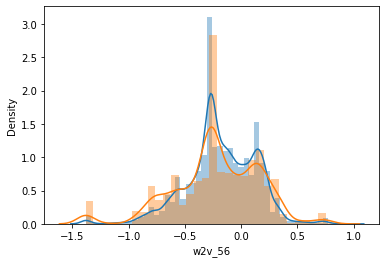

In [28]:
sns.distplot(train['w2v_56'])
sns.distplot(test['w2v_56'])

In [4]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [9]:
def safe_split(strs, n, sep='|'):
    str_li = strs.split(sep)
    if len(str_li) >= n + 1:
        return str_li[n].strip()
    else:
        return ''

In [13]:
log_df['msg_split_0'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 0))

In [14]:
log_df['msg_split_1'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 1))

In [15]:
log_df['msg_split_2'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 2))

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [33]:
cnt_list1 = []
cnt_list2 = []
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    label = row['label']
    if label > 1:
        continue
    
    sub_log1 = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log1 = sub_log1.tail(50)
    sub_log1 = sub_log1.sort_values(by='time')
    
    if label == 0:
        cnt_list1.append(sub_log1[(~(sub_log1['msg_lower'].str.startswith('system'))) &\
                                  (~(sub_log1['msg_lower'].str.startswith('processor')))].shape[0])
    if label == 1:
        cnt_list2.append(sub_log1[(~(sub_log1['msg_lower'].str.startswith('system'))) &\
                                  (~(sub_log1['msg_lower'].str.startswith('processor')))].shape[0])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [03:06<00:00, 89.04it/s]


/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

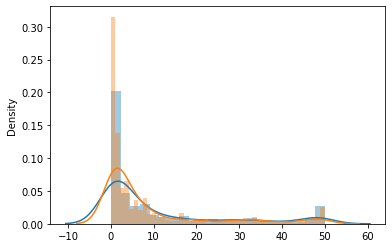

In [34]:
sns.distplot(cnt_list1)
sns.distplot(cnt_list2)

In [38]:
df_train = df_train[df_train['second_span_2h'] < 10000]

/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='processor_nunique', ylabel='Density'>

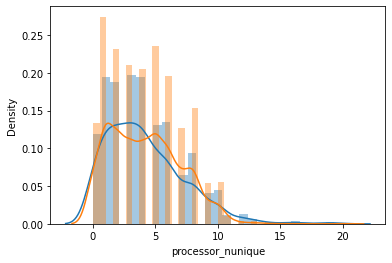

In [5]:
sns.distplot(df_train[df_train['label'] == 0]['processor_nunique'])
sns.distplot(df_train[df_train['label'] == 1]['processor_nunique'])

In [2]:
cnt_list = []
span_list = []
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    
    sub_log2 = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] >= fault_time_ts)]
    sub_log2 = sub_log2.sort_values(by='time')
    cnt_list.append(sub_log2.shape[0])
    
    if sub_log2.shape[0] > 0:
        span_list.append(sub_log2.iloc[0]['time_ts'] - fault_time_ts)
    else:
        span_list.append(0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [10:12<00:00, 27.11it/s]


In [2]:
dtype = {
    'server_model': 'str',
    'last_msg_id': 'str',
    'last_template_id': 'str',
    'tmp_appearance_1': 'str',
    'tmp_appearance_2': 'str',
    'tmp_appearance_3': 'str',
    'msg_appearance_1': 'str',
    'msg_appearance_2': 'str',
    'msg_appearance_3': 'str',
    'max_continuous_msg': 'str'
}
df_train = pd.read_csv('../code/train.csv', dtype=dtype)
df_test = pd.read_csv('../code/test.csv', dtype=dtype)

In [4]:
df_train['post_cnt'] = cnt_list
df_train['post_span'] = span_list

In [13]:
df_train[df_train['label'] == 1]

,sn,fault_time,server_model,last_msg_id,last_template_id,cnt_2h,percent_2h,msg_nunique_2h,template_nunique_2h,msg_percent_2h,...,tfv_11,tfv_12,tfv_13,tfv_14,tfv_15,crashdump_cnt,venus_cnt,label,post_cnt,post_span
1122,SERVER_12,2020-06-11 11:45:00,SM3,3,4,20,0.555556,10,8,0.500000,...,0.027940,-0.002537,-0.039212,0.035598,0.022161,0,0,1,127,10108374
1146,SERVER_588,2020-03-19 05:33:00,SM6,40,3,20,0.152672,5,4,0.250000,...,0.105329,-0.015719,-0.059050,0.021905,0.053710,0,0,1,1,38
1150,SERVER_437,2020-01-25 05:14:00,SM6,40,3,20,0.444444,5,5,0.250000,...,0.101827,-0.016031,-0.057791,0.016409,0.054206,0,0,1,1,15953037
1155,SERVER_567,2020-07-22 06:08:00,SM6,63,3,20,0.408163,10,5,0.500000,...,0.252862,-0.026811,-0.054421,-0.030950,0.053296,0,0,1,212,152557
1162,SERVER_742,2020-07-23 12:47:00,SM6,44,4,20,0.100503,6,6,0.300000,...,0.031872,-0.008087,-0.001633,-0.003949,0.016663,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16505,SERVER_25153,2020-01-26 05:32:00,SM103,219,1,6,1.000000,4,4,0.666667,...,-0.020619,-0.029800,0.010254,0.058465,0.021697,0,0,1,0,0
16522,SERVER_737,2020-04-21 11:32:00,SM5,101,2,3,1.000000,3,2,1.000000,...,-0.005538,-0.012617,-0.007139,-0.006633,0.029630,0,0,1,0,0
16524,SERVER_17042,2020-05-29 09:41:00,SM34,213,80,5,1.000000,4,3,0.800000,...,0.010265,-0.002381,0.034449,0.039888,0.019755,0,0,1,0,0
16535,SERVER_14848,2020-01-05 16:18:00,SM14,192,41,1,1.000000,1,1,1.000000,...,-0.004726,-0.005862,-0.000592,0.000343,0.006991,0,0,1,0,0


In [11]:
df_train[df_train['label'] == 0]

,sn,fault_time,server_model,last_msg_id,last_template_id,cnt_2h,percent_2h,msg_nunique_2h,template_nunique_2h,msg_percent_2h,...,tfv_11,tfv_12,tfv_13,tfv_14,tfv_15,crashdump_cnt,venus_cnt,label,post_cnt,post_span
0,SERVER_25698,2020-10-09 13:43:00,SM0,0,1,20,0.076923,1,1,0.05,...,0.006188,0.004494,-0.007211,-0.029983,-0.000066,0,0,0,0,0
1,SERVER_25699,2020-08-25 18:50:00,SM3,5,3,20,0.952381,9,8,0.45,...,0.024321,-0.003542,-0.035807,0.030520,0.023102,0,0,0,0,0
2,SERVER_25712,2020-03-16 13:20:00,SM4,3,4,20,0.238095,12,8,0.60,...,0.023686,-0.004972,-0.022471,0.023828,0.013383,0,0,0,0,0
3,SERVER_25708,2020-07-25 12:44:00,SM4,25,16,20,0.066225,2,2,0.10,...,0.004866,-0.005059,0.012442,-0.002809,-0.001592,0,0,0,0,0
4,SERVER_25711,2020-03-16 16:51:00,SM4,3,4,20,0.196078,8,7,0.40,...,0.025873,-0.002876,-0.020622,0.022176,0.013796,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16502,SERVER_27674,2020-07-04 16:58:00,SM103,220,1,3,1.000000,3,3,1.00,...,-0.014202,-0.052599,0.000740,0.229986,0.091953,0,0,0,0,0
16507,SERVER_27679,2020-08-24 08:41:00,SM103,968,176,4,1.000000,4,4,1.00,...,-0.005901,-0.005488,-0.007512,0.040658,0.020657,0,0,0,0,0
16509,SERVER_27659,2020-08-10 16:12:00,SM103,265,100,3,1.000000,3,3,1.00,...,-0.002180,-0.003510,0.011805,0.028328,0.017545,0,0,0,0,0
16513,SERVER_27680,2020-06-16 18:21:00,SM103,265,100,3,1.000000,3,3,1.00,...,-0.002180,-0.003510,0.011805,0.028328,0.017545,0,0,0,0,0


In [15]:
log_df[log_df['sn'] == 'SERVER_737']

,sn,time,msg,server_model,msg_lower,msg_id,template_id,template,time_ts
482142,SERVER_737,2020-04-21 11:12:11,Processor CPU1 Status | Uncorrectable machine...,SM5,processor cpu1 status | uncorrectable machine ...,49,2,processor <:*:> <:*:> | uncorrectable machine ...,1587467531
482148,SERVER_737,2020-04-21 11:12:36,Processor CPU1 Status | Uncorrectable machine...,SM5,processor cpu1 status | uncorrectable machine ...,101,2,processor <:*:> <:*:> | uncorrectable machine ...,1587467556
482152,SERVER_737,2020-04-21 11:12:35,System Boot Initiated SysRestart | System Res...,SM5,system boot initiated sysrestart | system rest...,44,4,system <:*:> <:*:> <:*:> | <:*:> <:*:> | asserted,1587467555


In [21]:
log_df[log_df['msg_lower'].str.startswith('system boot initiated')]

sn              28032
time            28032
msg             28032
server_model    28032
msg_lower       28032
msg_id          28032
template_id     28032
template        28032
time_ts         28032
dtype: int64

In [1]:
import pandas as pd

In [2]:
dtype = {
    'server_model': 'str',
    'last_msg_id': 'str',
    'last_template_id': 'str',
    'tmp_appearance_1': 'str',
    'tmp_appearance_2': 'str',
    'tmp_appearance_3': 'str',
    'msg_appearance_1': 'str',
    'msg_appearance_2': 'str',
    'msg_appearance_3': 'str',
    'max_continuous_msg': 'str'
}
df_train = pd.read_csv('../code/train.csv', dtype=dtype)
df_test = pd.read_csv('../code/test.csv', dtype=dtype)

In [4]:
import seaborn as sns

In [18]:
df_train = df_train[df_train['second_span_2h'] < 100000]

/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

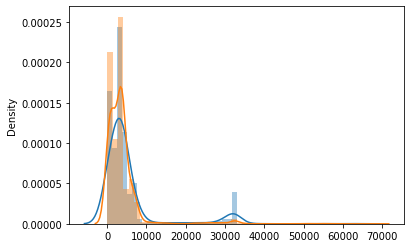

In [24]:
sns.distplot(df_train[df_train['label'] == 0]['second_span_2h'].values)
sns.distplot(df_train[df_train['label'] == 1]['second_span_2h'].values)